In [1]:
# pip install google-adk

In [1]:
import credentials
import os

In [2]:
GOOGLE_API_KEY = credentials.GOOGLE_API_KEY
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [3]:
# multi step workflows
from google.adk.agents import Agent, SequentialAgent, ParallelAgent, LoopAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import AgentTool, FunctionTool, google_search
from google.genai import types

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


In [4]:
retry_config=types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504], # Retry on these HTTP errors
)

## Architecture: Single Agent vs Multi-Agent Team

### Multi-agent Team

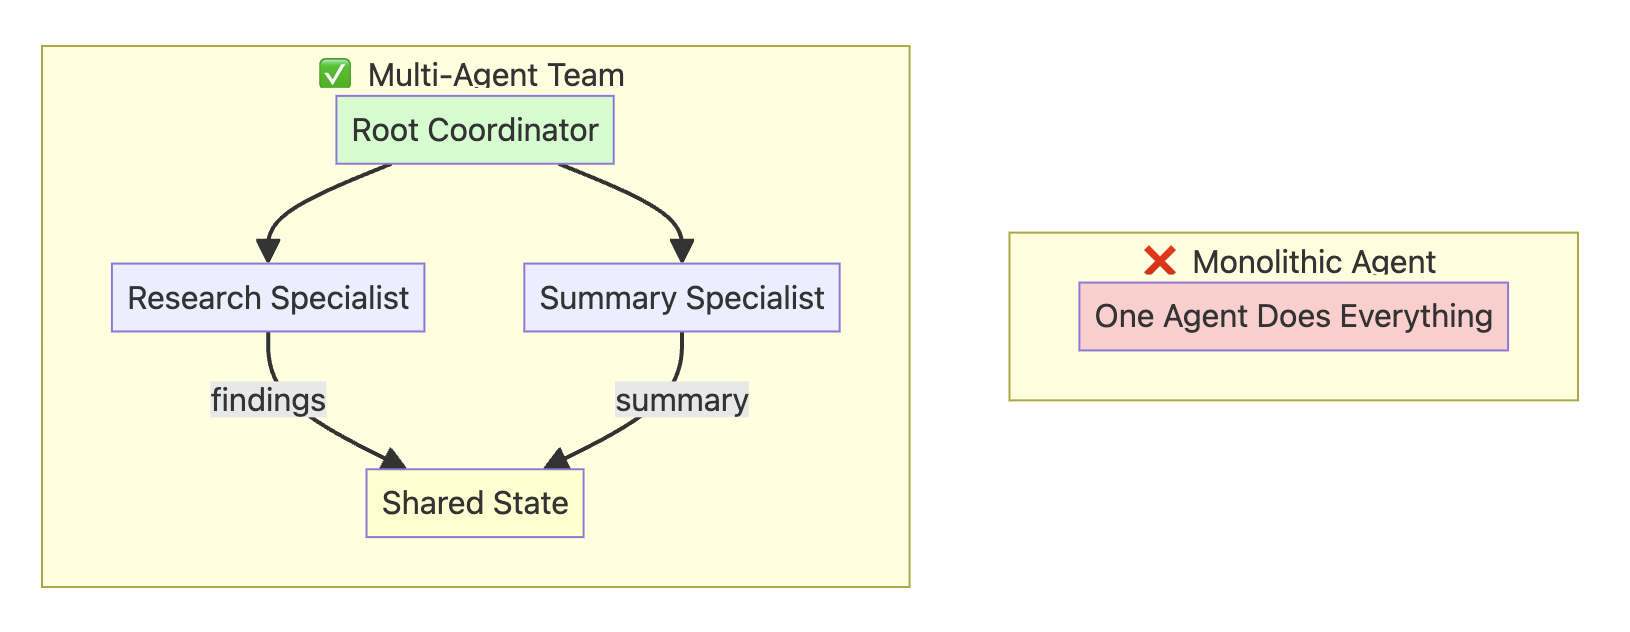

In [5]:
# Research Agent: Its job is to use the google_search tool and present findings.
research_agent = Agent(
    name="ResearchAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a specialized research agent. Your only job is to use the
    google_search tool to find 2-3 pieces of relevant information on the given topic and present the findings with citations.""",
    tools=[google_search],
    output_key="research_findings",  # The result of this agent will be stored in the session state with this key.
)

print("✅ research_agent created.")

✅ research_agent created.


In [6]:
# Summarizer Agent: Its job is to summarize the text it receives.
summarizer_agent = Agent(
    name="SummarizerAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # The instruction is modified to request a bulleted list for a clear output format.
    instruction="""Read the provided research findings: {research_findings}
Create a concise summary as a bulleted list with 3-5 key points.""",
    output_key="final_summary",
)

print("✅ summarizer_agent created.")

✅ summarizer_agent created.


In [7]:
# Root Coordinator: Orchestrates the workflow by calling the sub-agents as tools.
root_agent = Agent(
    name="ResearchCoordinator",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    # This instruction tells the root agent HOW to use its tools (which are the other agents).
    instruction="""You are a research coordinator. Your goal is to answer the user's query by orchestrating a workflow.
1. First, you MUST call the `ResearchAgent` tool to find relevant information on the topic provided by the user.
2. Next, after receiving the research findings, you MUST call the `SummarizerAgent` tool to create a concise summary.
3. Finally, present the final summary clearly to the user as your response.""",
    # We wrap the sub-agents in `AgentTool` to make them callable tools for the root agent.
    tools=[AgentTool(research_agent), AgentTool(summarizer_agent)],
)

print("✅ root_agent created.")

✅ root_agent created.


In [8]:
runner = InMemoryRunner(agent=root_agent)
response = await runner.run_debug(
    "What are the latest advancements in quantum computing and what do they mean for AI?"
)


 ### Created new session: debug_session_id

User > What are the latest advancements in quantum computing and what do they mean for AI?


ResearchCoordinator > Quantum computing is rapidly advancing, bringing transformative potential to Artificial Intelligence. Key developments include:

*   **Exponentially Enhanced Computational Power:** Quantum computers can process information exponentially faster than classical computers, drastically speeding up AI tasks like model training and complex calculations.
*   **Superior Optimization and Problem-Solving:** Quantum computing excels at optimization problems, enabling AI to revolutionize fields such as drug discovery, materials science, and financial modeling by simulating complex systems with unprecedented accuracy.
*   **More Efficient Data Handling and Novel Architectures:** Quantum Machine Learning (QML) algorithms promise more efficient processing and classification of large datasets. Additionally, Quantum Neural Networks (QNNs) offer new ways for AI to perform complex pattern recognition.
*   **Hybrid Approaches and Mutual Advancement:** Near-term applications often util

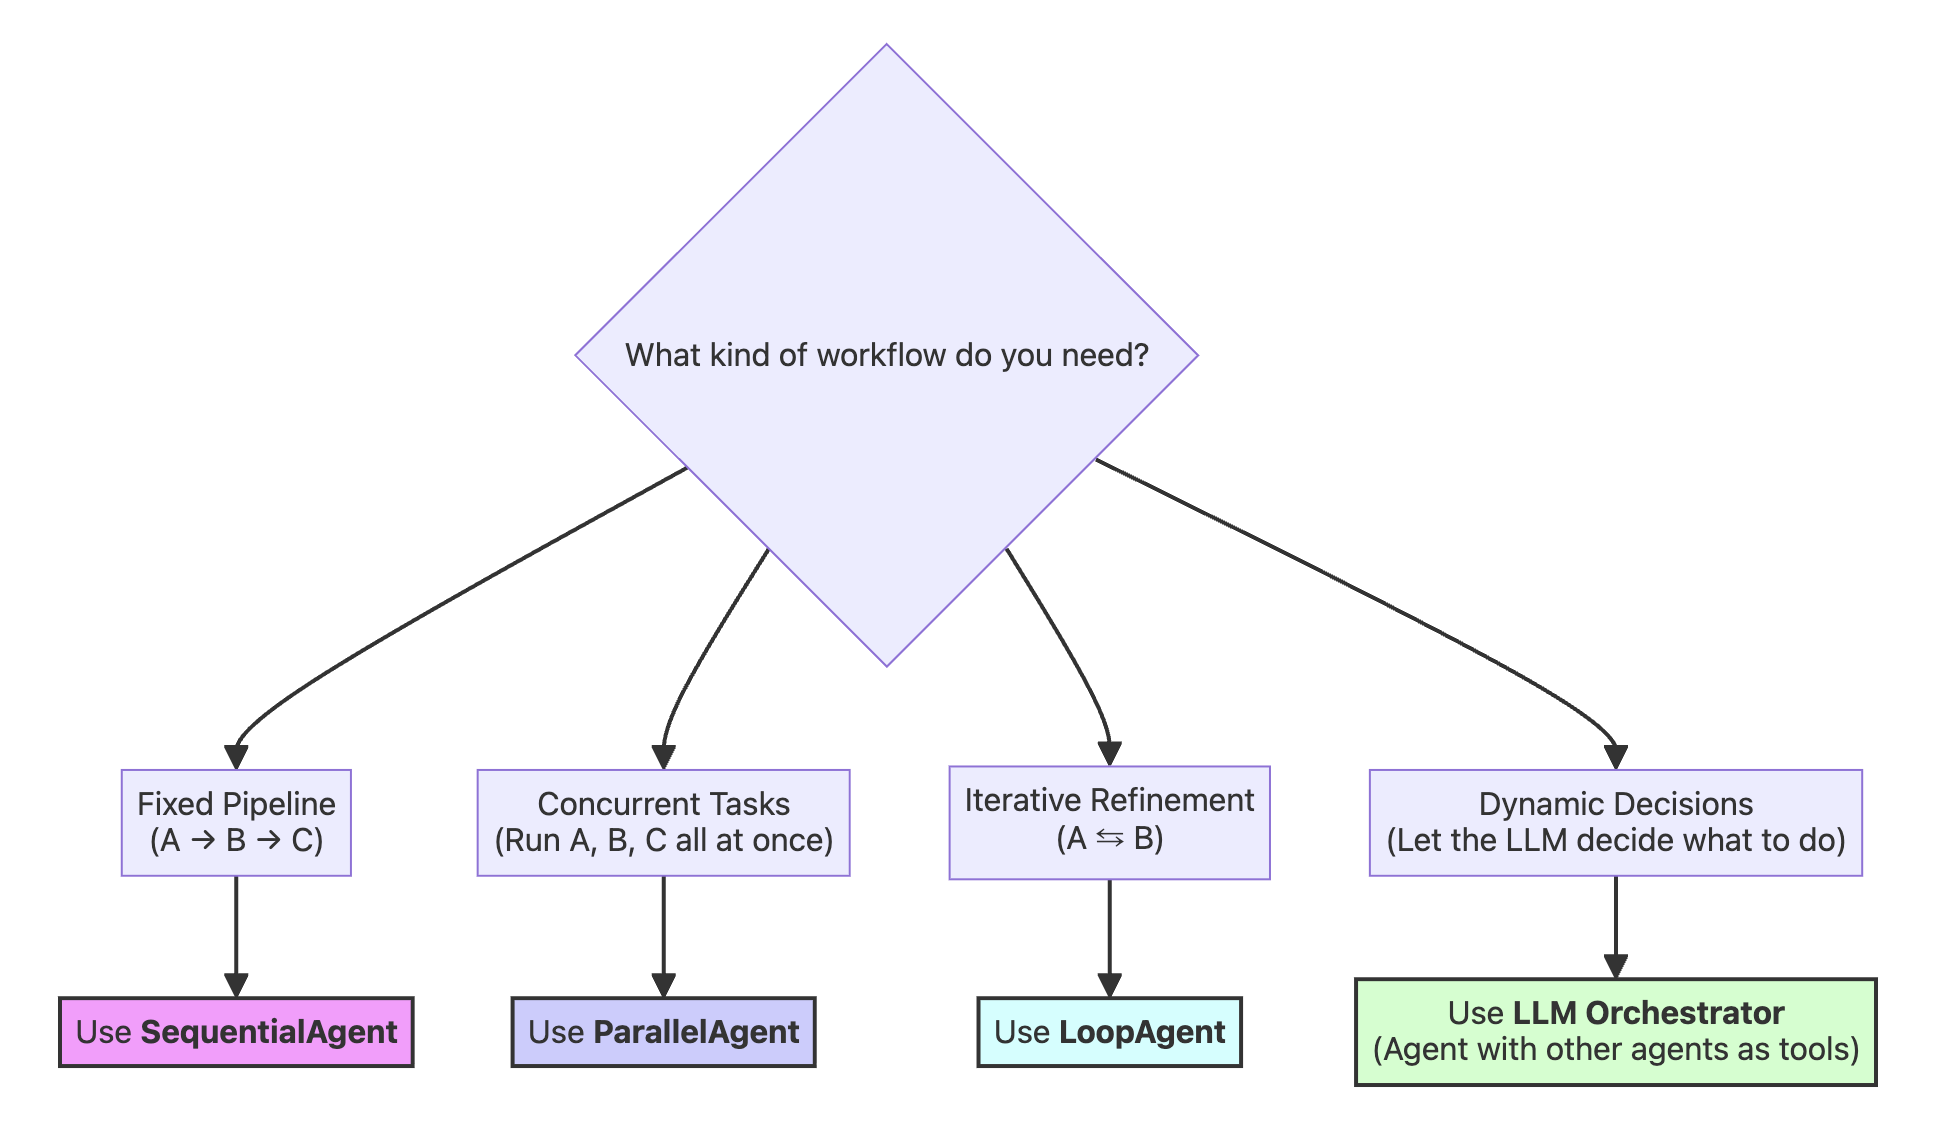